# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [172]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


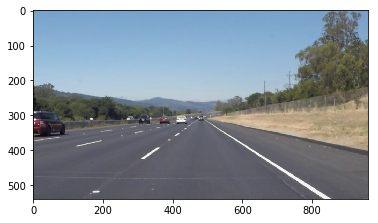

In [173]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [282]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left = []
    right = []
    imshape = img.shape
    for line in lines:
        for x1,y1,x2,y2 in line:
            #print('x1,y1,x2,y2')
            #print(x1,y1,x2,y2)
            if (x2> imshape[1]/2):
                # if the point is on right side of the screen then it's a right guy
            #if ((y2-y1)/(x2-x1))> 0:
                #positive slope means that it's right line
                #print('appends to right')
                right.append(line)
            else:
                #if not positive slope then negative slope
                #print('appends to left')
                left.append(line) 
                
            #print('right')
            #print(right)
           # print('left')
           # print(left)
            #cv2.line(img, (x1,y1), (x2,y2), color, thickness)
    
    
    leftX = average_x(left,imshape)
    rightX = average_x(right, imshape)
    
    #print('leftx0, left xf')
    #print(leftX[0], leftX[1])
    #print('rightx0, rightxf')
    #print(rightX[0], rightX[1])
    if (leftX[0] and leftX[1]):
        cv2.line(img, (leftX[0], int(imshape[0]/2+80)), (leftX[1], int(imshape[0])), color, thickness)
    if(rightX[0] and rightX[0]):
        cv2.line(img, (rightX[0], int(imshape[0]/2+80)), (rightX[1], int(imshape[0])), color, thickness)
   
   
def average_x(side,dim):
    x= []
    y = []
    Xo = []
    Xf = []
    for line in side:
        for x1,y1,x2,y2 in line:
            #create a fat list of x and ys
            x.append(x1)
            y.append(y1)
            x.append(x2)
            y.append(y2)
            
    #find equation y = mx+b using polyfit
    if (x and y):
        #skip if no x,y values
        z = np.polyfit(x,y,1)
    
       # print(z)
        m = z[0]
        b = z[1]
        Xo = int((dim[0]/2+70-b)/m)
        Xf = int((dim[0] - b)/m)
    '''
    Xo = []
    Xf = []
    try:
        for line in side:
            #aggregate all x and ys and create a polyfit
            for x1,y1,x2,y2 in line:
                
                #
                #y=mx+b
                #print('printing x1 y1...')
                #print(x1,y1,x2,y2)
                
                m = (y2-y1)/(x2-x1)
                b = y2 - m*x2
                #print('m and b')
                #print(m,b)
                if not np.isnan(m) and not np.isinf(m) and m != 0:
                    #print('append success!')
                    #print('Xo candidate')
                    #print((dim[0]/2+70-b)/m)
                    #print('Xf candidate')
                    #print((dim[0] - b)/m)
                    Xo.append((dim[0]/2+70-b)/m)
                    Xf.append((dim[0] - b)/m)
    except ValueError as e:
        #print(e)
        return (Xo, Xf)
    #print('printing Xo Xf')
    #print(Xo, Xf)
    if Xo and Xf:
        return (int(np.mean(Xo)),int(np.mean(Xf)))
    '''
    return (Xo,Xf)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [179]:
import os
files = os.listdir("test_images/")

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [180]:
#Test for os.listdir

   # plt.imshow(image)
   # print(file)
   

[  -0.79706727  691.06396885]
[  0.55980781  40.18837623]
[  -0.66041979  630.48125937]
[ 0.63973267 -0.79973466]
[  -0.71955328  656.41681697]
[  0.56521739  51.04347826]
[  -0.73633343  662.31886137]
[  0.57778034  38.85354809]
[  -0.70734375  644.72903594]
[ 0.63055622  4.18876761]
[  -0.76932207  682.16998209]
[  0.57399154  36.75407616]


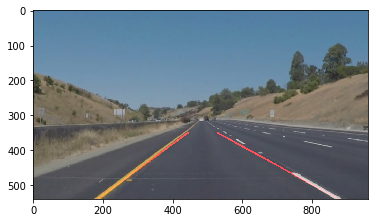

In [275]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.


# Read in and grayscale the image
for file in files:
    image = mpimg.imread("test_images/"+file)
    gray = grayscale(image)
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(image, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)


    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    #print(imshape)
    vertices = np.array([[(0,imshape[0]),(imshape[1]/2-80,imshape[0]/2+70), (imshape[1]/2+80,imshape[0]/2+70), (imshape[1],imshape[0])]], dtype=np.int32)
    #print(vertices)
    masked_edges = region_of_interest(edges, vertices)



    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 50     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 10   # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    line_image = hough_lines(masked_edges, rho, theta, threshold, 
                                min_line_length, max_line_gap)



    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image

    lines_edges = weighted_img(line_image, image, 0.8,1,0)

    plt.imshow(lines_edges)
    plt.savefig("test_images_output/"+file, bbox_inches='tight')



## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [211]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [264]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    gray = grayscale(image)
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(image, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    #print(imshape)
    vertices = np.array([[(0,imshape[0]),(imshape[1]/2-80,imshape[0]/2+70), (imshape[1]/2+80,imshape[0]/2+70), (imshape[1],imshape[0])]], dtype=np.int32)
    #print(vertices)
    
    masked_edges = region_of_interest(edges, vertices)
    #plt.figure()
    #plt.imshow(masked_edges)
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 20   # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    line_image = hough_lines(masked_edges, rho, theta, threshold, 
                                min_line_length, max_line_gap)



    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image

    lines_edges = weighted_img(line_image, image, 0.8,1,0)

    
    return lines_edges

Let's try the one with the solid white lane on the right first ...

In [281]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(8,9)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[  -0.72050256  651.21687808]
[  0.60697342  15.4605882 ]
leftx0, left xf
431 154
rightx0, rightxf
534 864
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



  2%|▏         | 4/222 [00:00<00:05, 36.89it/s]

[  -0.72050256  651.21687808]
[  0.60697342  15.4605882 ]
leftx0, left xf
431 154
rightx0, rightxf
534 864
[  -0.73858072  656.95517488]
[ 0.61818085  8.66432896]
leftx0, left xf
429 158
rightx0, rightxf
535 859
[  -0.72249575  651.03455498]
[  0.60674675  15.63610488]
leftx0, left xf
430 153
rightx0, rightxf
534 864
[  -0.73862351  657.10480878]
[  0.60820135  14.45583291]
leftx0, left xf
429 158
rightx0, rightxf
535 864
[  -0.73136666  652.97937606]
[ 0.61772051  8.75585502]
leftx0, left xf
427 154
rightx0, rightxf
536 860
[  -0.72193563  649.77468132]
[ 0.62745657  2.49853498]
leftx0, left xf
429 152
rightx0, rightxf
537 856
[  -0.80993897  684.37183958]
[ 0.61393795  9.03754445]
leftx0, left xf
425 178
rightx0, rightxf
539 864



  4%|▍         | 9/222 [00:00<00:05, 38.94it/s]

[  -0.7  639.2]
[  0.60055566  18.32024301]
leftx0, left xf
427 141
rightx0, rightxf
535 868
[  -0.68465243  637.46437832]
[ 0.62075132  7.46543092]
leftx0, left xf
434 142
rightx0, rightxf
535 857



  6%|▌         | 13/222 [00:00<00:05, 39.16it/s]

[  -0.70020121  643.46478873]
[  0.60973016  15.31601814]
leftx0, left xf
433 147
rightx0, rightxf
532 860
[  -0.70999667  649.35053477]
[  0.61778193  14.54230599]
leftx0, left xf
435 154
rightx0, rightxf
526 850
[  -0.71853899  652.89374485]
[ 0.63319447  4.49205034]
leftx0, left xf
435 157
rightx0, rightxf
529 845
[  -0.7046804   647.10320285]
[  0.62387387  11.14527027]
leftx0, left xf
435 151
rightx0, rightxf
527 847
[  -0.71559758  648.95365099]
[ 0.62689033  6.42783367]
leftx0, left xf
431 152
rightx0, rightxf
532 851
[  -0.70147782  641.84383832]
[ 0.64252416 -2.69179495]
leftx0, left xf
430 145
rightx0, rightxf
533 844
[  -0.709072    642.82700152]
[ 0.63654752 -2.1217036 ]


  8%|▊         | 17/222 [00:00<00:05, 38.75it/s]


leftx0, left xf
427 145
rightx0, rightxf
537 851
[  -0.71449505  644.79704482]
[ 0.64665823 -7.73259754]
leftx0, left xf
426 146
rightx0, rightxf
537 847



  9%|▉         | 21/222 [00:00<00:05, 38.00it/s]

[  -0.71021803  644.14025382]
[ 0.63286967  0.56101379]
leftx0, left xf
428 146
rightx0, rightxf
536 852
[  -0.77777778  671.66666667]
[ 0.63866406 -0.02645488]
leftx0, left xf
426 169
rightx0, rightxf
532 845
[  -0.7  640.2]
[ 0.63267585  3.61682048]
leftx0, left xf
428 143
rightx0, rightxf
531 847
[  -0.69714196  643.93353556]
[ 0.64474279 -2.62688834]
leftx0, left xf
435 149
rightx0, rightxf
531 841
[  -0.68708456  640.21929495]
[ 0.64221725 -0.67520931]
leftx0, left xf
436 145
rightx0, rightxf
530 841
[  -0.68429894  638.64081577]
[ 0.64314045 -1.38791482]
leftx0, left xf
436 144
rightx0, rightxf
530 841
[  -0.67780693  634.98886748]
[ 0.63581227  3.14765743]
leftx0, left xf
435 


 11%|█▏        | 25/222 [00:00<00:05, 37.37it/s]

140
rightx0, rightxf
529 844
[  -0.69961583  644.94377657]
[ 0.6437168  -3.08025585]
leftx0, left xf
435 150
rightx0, rightxf
532 843



 13%|█▎        | 29/222 [00:00<00:05, 37.08it/s]

[  -0.69745702  641.85655509]
[ 0.64175493 -1.91569143]
leftx0, left xf
432 146
rightx0, rightxf
532 844
[  -0.71040679  646.66439497]
[ 0.63615935  1.71390788]
leftx0, left xf
431 150
rightx0, rightxf
531 846
[  -0.70580277  646.69639767]
[ 0.63379808  2.71597761]
leftx0, left xf
434 151
rightx0, rightxf
532 847
[  -0.69809951  643.6518411 ]
[ 0.63904222 -0.87943249]
leftx0, left xf
434 148
rightx0, rightxf
533 846
[  -0.70815858  645.25838219]
[ 0.65204701 -8.30801329]
leftx0, left xf
431 148
rightx0, rightxf
534 840
[  -0.7211492   652.16163689]
[ 0.62623542  5.00151231]
leftx0, left xf
432 155
rightx0, rightxf
534 854
[ 0.63861227 -1.94386558]
leftx0, left xf
[] []
rightx0, rightxf
535 848



 15%|█▍        | 33/222 [00:00<00:05, 36.77it/s]

[  -0.68119945  636.17116517]
[ 0.63018157  2.6941392 ]
leftx0, left xf
434 141
rightx0, rightxf
535 852



 17%|█▋        | 38/222 [00:00<00:04, 38.28it/s]

[  -0.69553293  643.13525867]
[ 0.6432287  -4.87771519]
leftx0, left xf
435 148
rightx0, rightxf
536 847
[  -0.72076298  651.78398999]
[ 0.64219714 -4.17695077]
leftx0, left xf
432 155
rightx0, rightxf
535 847
[  -0.71909309  652.27864361]
[ 0.6290129   6.01320305]
leftx0, left xf
434 156
rightx0, rightxf
530 848
[  -0.70015976  645.32011939]
[ 0.6266653   8.72383593]
leftx0, left xf
436 150
rightx0, rightxf
528 847
[  -0.70576602  646.61916907]
[ 0.63650837  2.29113131]
leftx0, left xf
434 151
rightx0, rightxf
530 844
[  -0.71538559  648.3024195 ]
[ 0.65169865 -8.18081589]
leftx0, left xf
430 151
rightx0, rightxf
534 841
[  -0.71824343  648.81733033]
[ 0.65138635 -7.8553692 ]
leftx0, left xf
429 151
rightx0, rightxf
534 841
[  -0.74866433  659.3106396 ]
[ 0.63794351 -0.37566458]
leftx0, left xf
426 159
rightx0, rightxf


533 847
[  -0.7447352  658.4401544]
[ 0.64727141 -8.49421509]
leftx0, left xf
427 159
rightx0, rightxf
538


 21%|██        | 46/222 [00:01<00:04, 36.46it/s]

 847
[  -0.73606995  654.16454258]
[ 0.64653233 -8.11774493]
leftx0, left xf
426 155
rightx0, rightxf
538 847
[  -0.859375  701.0625  ]
[ 0.63368772  0.14610866]
leftx0, left xf
420 187
rightx0, rightxf
536 851
[  -0.68293148  635.86133613]
[ 0.64444237 -6.13886472]
leftx0, left xf
433 140
rightx0, rightxf
537 847
[  -0.70311666  641.46343366]
[ 0.64692271 -7.90205284]
leftx0, left xf
428 144
rightx0, rightxf
537 846
[  -0.71964035  649.16172349]
[ 0.64925422 -6.83802172]
leftx0, left xf
429 151
rightx0, rightxf
534 842
[  -0.69180978  637.68159401]
[ 0.6337121   0.32314688]
leftx0, left xf
430 141
rightx0, rightxf
536 851


[  -0.73147608  652.62901148]
[ 0.64742532 -7.95108872]
leftx0, left xf
427 153
rightx0, rightxf
537 846
[  -0.72031667  647.43876094]
[  0.65760572 -14.70186101]


 24%|██▍       | 54/222 [00:01<00:04, 34.62it/s]


leftx0, left xf
426 149
rightx0, rightxf
539 843
[  -0.71001228  644.56725183]
[ 0.6448991  -6.43473141]
leftx0, left xf
428 147
rightx0, rightxf
537 847
[  -0.70833469  641.79548316]
[  0.65263746 -12.42935646]
leftx0, left xf
426 143
rightx0, rightxf
540 846
[  -0.73991132  651.96899803]
[ 0.64644464 -8.03059694]
leftx0, left xf
421 151
rightx0, rightxf
538 847
[  -0.68633852  631.92434706]
[ 0.64343592 -5.82194447]
leftx0, left xf
425 133
rightx0, rightxf
537 848
[ 0.6454119  -6.22668321]
leftx0, left xf
[] []
rightx0, rightxf
536 846


[ 0.65263455 -9.17365167]
leftx0, left xf
[] []
rightx0, rightxf
535 841
[  -0.66480163  627.21414039]
[ 0.65033757 -6.0016789 ]
leftx0, left xf
432 131
rightx0, rightxf
532 839



 26%|██▌       | 58/222 [00:01<00:04, 34.45it/s]

[  -0.66435185  627.59027778]
[ 0.6550362  -9.24354494]
leftx0, left xf
432 131
rightx0, rightxf
533 838
[  -0.69763592  639.51946938]
[ 0.64733595 -4.16373112]
leftx0, left xf
429 142
rightx0, rightxf
531 840
[  -0.68310657  633.72136974]
[ 0.65133979 -7.92125513]
leftx0, left xf
429 137
rightx0, rightxf
534 841
[  -0.70064761  639.2440352 ]
[ 0.65185522 -7.34976982]
leftx0, left xf
427 141
rightx0, rightxf
532 839



 28%|██▊       | 62/222 [00:01<00:04, 33.54it/s]

[  -0.69572542  638.37831292]
[  0.658606   -10.98223679]
leftx0, left xf
428 141
rightx0, rightxf
532 836
[  -0.69661391  638.89487812]
[ 0.64361866 -1.61324809]
leftx0, left xf
429 141
rightx0, rightxf
530 841
[  -0.68309232  634.41333711]
[ 0.64456973 -1.44310152]
leftx0, left xf
431 138
rightx0, rightxf
529 840



 30%|██▉       | 66/222 [00:01<00:04, 33.88it/s]

[  -0.66379109  624.95826533]
[ 0.64927612 -4.02618204]
leftx0, left xf
429 127
rightx0, rightxf
529 837
[  -0.68113922  631.93059152]
[  0.65672137 -10.00793053]
leftx0, left xf
428 134
rightx0, rightxf
532 837
[  -0.74242424  655.07575758]
[ 0.64609855 -5.49740088]
leftx0, left xf
424 155
rightx0, rightxf
534 844
[  -0.6  599.2]
[  0.65702914 -10.47244146]
leftx0, left xf
432 98
rightx0, rightxf
533 837
[  -0.65000171  619.8318199 ]


[ 0.64579847 -1.74023645]
leftx0, left xf
430 122
rightx0, rightxf
529 838
[  -0.67809463  630.37426071]
[ 0.65238441 -7.78746066]



 32%|███▏      | 70/222 [00:01<00:04, 33.73it/s]

leftx0, left xf
428 133
rightx0, rightxf
533 839
[  -0.65747352  621.62428778]
[ 0.64699724 -4.10616501]
leftx0, left xf
428 124
rightx0, rightxf
531 840
[  -0.65407013  621.21957799]


 33%|███▎      | 74/222 [00:02<00:04, 33.97it/s]


[  0.6620694  -11.93669482]
leftx0, left xf
429 124
rightx0, rightxf
531 833
[  -0.66799152  625.93706837]
[  0.66512133 -12.78372784]
leftx0, left xf
428 128
rightx0, rightxf
530 831
[  -0.68329462  630.30661395]
[ 0.65346984 -7.49599178]
leftx0, left xf
424 132
rightx0, rightxf
531 837
[  -0.66872642  625.53291405]
[ 0.65094189 -4.13105506]
leftx0, left xf
426 127
rightx0, rightxf
528 835


[  -0.6790499   627.97254571]
[  0.66711269 -13.82167127]
leftx0, left xf
424 129
rightx0, rightxf
530 830
[  -0.64820339  615.69803517]
[ 0.65839987 -6.67419906]
leftx0, left xf
425 116
rightx0, rightxf
526 830
[  -0.77966102  666.77966102]
[ 0.66238497 -9.3133764 ]


 35%|███▌      | 78/222 [00:02<00:04, 33.90it/s]


leftx0, left xf
419 162
rightx0, rightxf
527 829
[  -0.72727273  646.81818182]



 37%|███▋      | 82/222 [00:02<00:04, 34.90it/s]

[  0.6860326  -25.61147197]
leftx0, left xf
421 146
rightx0, rightxf
532 824
[  -0.6  597.4]
[  0.67196502 -14.45328923]
leftx0, left xf
429 95
rightx0, rightxf
527 825
[  -0.64217157  613.63227355]
[  0.67402366 -17.80009436]
leftx0, left xf
426 114
rightx0, rightxf
530 827
[  -0.62884646  610.69360615]
[  0.66597605 -12.55182748]
leftx0, left xf
430 112
rightx0, rightxf
529 829
[  -0.65085218  618.31369117]
[  0.67192072 -16.40658048]
leftx0, left xf
427 120
rightx0, rightxf
530 828



 39%|███▊      | 86/222 [00:02<00:03, 35.55it/s]

[  -0.67517152  625.37996394]
[  0.67393778 -16.69918446]
leftx0, left xf
422 126
rightx0, rightxf
529 826
[  -0.66367013  622.56990593]
[  0.67037016 -14.4166989 ]
leftx0, left xf
425 124
rightx0, rightxf
528 827
[  -0.66352289  623.34477007]
[  0.67214253 -17.31950038]
leftx0, left xf
427 125
rightx0, rightxf
531 829
[  -0.66043636  621.65842862]
[  0.69851793 -33.62261997]
leftx0, left xf
426 123
rightx0, rightxf
534 821



 41%|████      | 90/222 [00:02<00:03, 36.11it/s]

[  -0.65810593  621.90475924]
[  0.67596343 -18.67761078]
leftx0, left xf
428 124
rightx0, rightxf
530 826
[  -0.63304207  613.66043542]
[  0.68802666 -24.88215577]
leftx0, left xf
432 116
rightx0, rightxf
530 821
[  -0.68682824  633.50179136]
[  0.67831123 -17.76667186]
leftx0, left xf
427 136
rightx0, rightxf
527 822
[  -0.70212766  639.4893617 ]
[  0.69275637 -28.84945702]
leftx0, left xf
426 141
rightx0, rightxf
532 821



 42%|████▏     | 94/222 [00:02<00:03, 36.55it/s]

[  -0.625  609.625]
[  0.67681082 -15.95142628]
leftx0, left xf
431 111
rightx0, rightxf
525 821
[  -0.64917951  620.05382894]
[  0.67818053 -19.46869754]
leftx0, left xf
431 123
rightx0, rightxf
530 824
[  -0.62321324  611.9806954 ]
[  0.68664853 -23.98367329]
leftx0, left xf
436 115
rightx0, rightxf
530 821
[  -0.65461956  620.72687472]
[  0.69349749 -29.23443073]
leftx0, left xf
428 123
rightx0, rightxf
532 820



 44%|████▍     | 98/222 [00:02<00:03, 36.66it/s]

[  -0.65020115  620.43699317]
[  0.68477924 -24.86886739]
leftx0, left xf
431 123
rightx0, rightxf
532 824
[  -0.65730739  622.23061489]
[  0.69471659 -31.86359165]
leftx0, left xf
429 125
rightx0, rightxf
535 823
[  -0.67240409  626.71450304]
[  0.69762246 -34.19427841]
leftx0, left xf
426 128
rightx0, rightxf
536 823
[  -0.65650396  620.78706609]
[  0.69795998 -35.60086751]
leftx0, left xf
427 123
rightx0, rightxf
538 824



 46%|████▌     | 102/222 [00:02<00:03, 37.50it/s]

[  -0.6561361   619.42683748]
[  0.70727362 -43.15407985]
leftx0, left xf
425 121
rightx0, rightxf
541 824
[  -0.65736553  622.90075866]
[  0.69589795 -34.30278432]
leftx0, left xf
430 126
rightx0, rightxf
537 825
[  -0.67744402  631.47209175]
[  0.69427218 -31.25949718]
leftx0, left xf
430 135
rightx0, rightxf
534 822
[  -0.77464789  668.8028169 ]
[  0.68745044 -26.12336987]
leftx0, left xf


 48%|████▊     | 106/222 [00:02<00:03, 36.15it/s]


424 166
rightx0, rightxf
532 823
[  -0.65853659  624.68292683]
[  0.68845204 -28.27873281]
leftx0, left xf
432 128
rightx0, rightxf
534 825
[  -0.6745531   631.82439537]
[  0.67885147 -22.7777723 ]
leftx0, left xf
432 136
rightx0, rightxf
534 829
[  -0.67387489  630.30423437]
[  0.67770798 -24.41988609]
leftx0, left xf
430 134
rightx0, rightxf
537 832
[  -0.68305495  633.79256044]
[  0.68832502 -30.58296927]
leftx0, left xf
430 137
rightx0, rightxf


538 828
[  -0.636351    621.32362954]
[  0.66985643 -19.65548137]
leftx0, left xf
442 127
rightx0, rightxf
536 835
[  -0.67310177  631.73040259]
[  0.67456526 -21.8598479 ]
leftx0, left xf
433 136
rightx0, rightxf
536 832
[  -0.68769512  635.76929981]
[  0.69001299 -30.59026428]
leftx0, left xf
430 139
rightx0, rightxf
537 826



 50%|████▉     | 110/222 [00:03<00:03, 35.71it/s]

[  -0.68326773  635.09143972]


 51%|█████▏    | 114/222 [00:03<00:03, 34.91it/s]


[  0.68781371 -29.11588045]
leftx0, left xf
431 139
rightx0, rightxf
536 827
[  -0.67719432  634.49245479]
[  0.67232643 -21.44020626]
leftx0, left xf
434 139
rightx0, rightxf
537 835
[  -0.66238522  626.59207944]
[  0.66881919 -20.42879218]
leftx0, left xf
432 130
rightx0, rightxf
538 837
[  -0.68873069  635.69978794]
[  0.67632952 -24.84035955]
leftx0, left xf
429 138
rightx0, rightxf
539 835


[  -0.7014218   640.48341232]
[  0.68012716 -29.63023698]
leftx0, left xf
428 143
rightx0, rightxf
543 837
[  0.67798427 -26.59876102]
leftx0, left xf
[] []
rightx0, rightxf
540 835
[  -0.67176326  627.77990136]
[  0.67547799 -26.50398939]
leftx0, left xf
428 130
rightx0, rightxf
542 838
[  -0.66259372  625.67120244]


 53%|█████▎    | 118/222 [00:03<00:02, 35.12it/s]


[  0.66527221 -18.637195  ]
leftx0, left xf
431 129
rightx0, rightxf
539 839



 55%|█████▍    | 122/222 [00:03<00:02, 35.63it/s]

[  -0.68101904  632.79763965]
[  0.65361344 -12.01306017]
leftx0, left xf
429 136
rightx0, rightxf
538 844
[  -0.67165354  630.24639152]
[  0.6545812  -11.24811904]
leftx0, left xf
432 134
rightx0, rightxf
536 842
[  -0.67367926  632.1549123 ]
[  0.65323698 -11.97722753]
leftx0, left xf
433 136
rightx0, rightxf
538 844
[  -0.67882684  634.23567683]
[ 0.64074467 -4.40406784]
leftx0, left xf
433 138
rightx0, rightxf
537 849



 57%|█████▋    | 126/222 [00:03<00:02, 36.70it/s]

[  -0.67214059  631.17108917]
[ 0.64155243 -5.59387666]
leftx0, left xf
433 135
rightx0, rightxf
538 850
[  -0.68696187  637.65678257]
[  0.65425395 -11.90632159]
leftx0, left xf
433 142
rightx0, rightxf
537 843
[  -0.66200279  628.15911698]
[ 0.6419978  -3.10370857]
leftx0, left xf
435 133
rightx0, rightxf
534 845
[  -0.67692308  634.2       ]
[ 0.64438151 -4.26477828]
leftx0, left xf
434 139
rightx0, rightxf
534 844
[  -0.65436575  625.06088075]


 59%|█████▊    | 130/222 [00:03<00:02, 36.40it/s]


[ 0.62610635  4.89351474]
leftx0, left xf
435 129
rightx0, rightxf
535 854
[ 0.63105664  1.42956413]
leftx0, left xf
[] []
rightx0, rightxf
536 853
[  -0.69623075  642.84883815]
[ 0.64595163 -8.99580598]
leftx0, left xf
434 147
rightx0, rightxf
540 849
[  -0.68105601  638.60749197]
[ 0.62831792  2.90091927]
leftx0, left xf
438 144
rightx0, rightxf
536 854



 60%|██████    | 134/222 [00:03<00:02, 35.51it/s]

[  -0.69372049  643.10121881]
[ 0.64272931 -5.87429195]
leftx0, left xf
436 148
rightx0, rightxf
538 849
[  -0.68088363  641.90126453]
[ 0.62673875  4.70134701]
leftx0, left xf
443 149
rightx0, rightxf
534 854
[  -0.69098581  644.14937464]
[ 0.63401868 -0.83043327]
leftx0, left xf
440 150
rightx0, rightxf
537 853
[  -0.70392474  646.57973008]
[ 0.63031406  3.81081524]
leftx0, left xf
435 151
rightx0, rightxf
533 850
[  -0.7050454   645.65220541]


[ 0.62914463  3.17460549]
leftx0, left xf
433 149
rightx0, rightxf
535 853
[  -0.70587635  645.09617739]
[ 0.63675853 -4.01771082]
leftx0, left xf
432 148
rightx0, rightxf
540 854
[  -0.70032653  643.66330112]
[ 0.62387633  2.59095802]
leftx0, left xf
433 148
rightx0, rightxf
540 861
[  -0.68726251  637.25830167]


 62%|██████▏   | 138/222 [00:03<00:02, 35.40it/s]


[ 0.6311861  -0.16565691]
leftx0, left xf
432 141
rightx0, rightxf
538 855
[  -0.7306893   655.22491629]
[  0.61476781  10.9836587 ]
leftx0, left xf
431 157
rightx0, rightxf
535 860
[ 0.62667906  3.45955683]
leftx0, left xf
[] []
rightx0, rightxf
537 856
[  -0.73170732  655.07317073]
[ 0.63283792 -0.20124352]
leftx0, left xf
430 157
rightx0, rightxf
537 853
[  -0.68314783  640.28715424]


 66%|██████▌   | 146/222 [00:04<00:02, 35.71it/s]


[ 0.62815506  4.06734735]
leftx0, left xf
439 146
rightx0, rightxf
534 853
[  -0.70626004  650.6013275 ]
[ 0.6416136  -3.50862659]
leftx0, left xf
439 156
rightx0, rightxf
535 847
[  -0.72865192  659.00030019]
[ 0.64670074 -6.68986056]
leftx0, left xf
437 163
rightx0, rightxf
536 845
[  -0.67316743  640.83812356]
[ 0.63766255 -1.61106459]
leftx0, left xf
446 149
rightx0, rightxf
535 849
[  -0.7174504   653.54040567]
[ 0.63094244 -0.62634614]
leftx0, left xf
437 158
rightx0, rightxf
539 856



 68%|██████▊   | 150/222 [00:04<00:02, 35.31it/s]

[  -0.71334437  650.9580905 ]
[ 0.63904998 -6.52864686]
leftx0, left xf
435 155
rightx0, rightxf
542 855
[  -0.71415206  651.19818446]
[ 0.63456247 -3.95340488]
leftx0, left xf
435 155
rightx0, rightxf
542 857
[  -0.72021063  654.00262128]
[ 0.63332334 -4.69527604]
leftx0, left xf
435 158
rightx0, rightxf
544 860
[  -0.73144308  658.24862255]
[ 0.63064193 -1.07854231]
leftx0, left xf
435 161
rightx0, rightxf
540 857



 69%|██████▉   | 154/222 [00:04<00:01, 35.22it/s]

[  -0.74131196  662.86133858]
[ 0.61554004  8.52897493]
leftx0, left xf
435 165
rightx0, rightxf
538 863
[ 0.63211377 -2.90937544]
leftx0, left xf
[] []
rightx0, rightxf
542 858
[  -0.69384615  645.44307692]
[ 0.63396793 -5.07601854]
leftx0, left xf
440 151
rightx0, rightxf
544 859
[  -0.68620505  643.10885668]
[ 0.63974139 -9.49465874]
leftx0, left xf
441 150
rightx0, rightxf
546 858


[  -0.71955208  655.0357147 ]
[ 0.62741841 -0.41787372]
leftx0, left xf
437 159
rightx0, rightxf
542 861
[  -0.70858494  650.16102667]
[ 0.63094129 -5.08723467]
leftx0, left xf
437 155
rightx0, rightxf
546 863
[  -0.72420788  657.71504666]
[ 0.61659111  4.99208264]
leftx0, left xf
438 162
rightx0, rightxf
543 867



 71%|███████   | 158/222 [00:04<00:01, 34.11it/s]

[  -0.71335747  652.69844153]
[ 0.61366203  7.75662362]
leftx0, left xf
438 157
rightx0, rightxf
541 867
[  -0.72111893  655.44431022]
[ 0.61493007  6.76753406]
leftx0, left xf
437 160
rightx0, rightxf
541 867
[  -0.73472407  660.79766165]
[ 0.60923658  7.36228844]
leftx0, left xf
436 164
rightx0, rightxf
545 874
[  -0.74472785  666.20387088]
[ 0.6055016   8.76702505]
leftx0, left xf
438 169
rightx0, rightxf
547 877
[  -0.77241291  678.96401127]
[ 0.60912308  8.69290602]
leftx0, left xf



 73%|███████▎  | 162/222 [00:04<00:01, 34.89it/s]

438 179
rightx0, rightxf
543 872
[  -0.74509736  667.61410717]
[  0.58089837  27.30779641]
leftx0, left xf
439 171
rightx0, rightxf
538 882
[  -0.86153846  714.87692308]
[  0.58878796  22.14369944]
leftx0, left xf
435 202
rightx0, rightxf
539 879
[  0.59129455  20.44872492]


 75%|███████▍  | 166/222 [00:04<00:01, 34.81it/s]


leftx0, left xf
[] []
rightx0, rightxf
540 878
[  -0.73443968  665.69994505]
[  0.59406078  16.97203187]
leftx0, left xf
443 171
rightx0, rightxf
543 880
[  -0.75572418  674.07487403]
[  0.5991968   17.34720247]
leftx0, left xf
442 177
rightx0, rightxf
538 872
[  -0.76665787  677.95875635]
[  0.59311126  21.65214935]
leftx0, left xf
440 179
rightx0, rightxf
536 873
[  -0.76417703  676.27861916]
[  0.58903377  22.86806633]
leftx0, left xf
440 178
rightx0, rightxf
538 877
[  -0.72801741  668.2955179 ]



 77%|███████▋  | 170/222 [00:04<00:01, 34.48it/s]

[  0.58888539  22.189741  ]
leftx0, left xf
450 176
rightx0, rightxf
539 879
[  -0.76384985  676.02295159]
[  0.58995049  23.33614018]
leftx0, left xf
439 178
rightx0, rightxf
536 875
[  -0.77867733  682.21715587]
[  0.58736497  23.7312599 ]
leftx0, left xf
439 182
rightx0, rightxf
538 878



 78%|███████▊  | 174/222 [00:04<00:01, 33.58it/s]

[  -0.79204238  687.66367373]
[  0.5857425   25.03241563]
leftx0, left xf
438 186
rightx0, rightxf
537 879
[  -0.77455341  679.97593875]
[  0.59097769  23.24967403]
leftx0, left xf
438 180
rightx0, rightxf
535 874
[  -0.7677842   676.96200385]
[  0.57780932  30.69032219]
leftx0, left xf
438 178
rightx0, rightxf
535 881
[  -0.80725701  695.06550518]
[  0.58263925  25.86858612]
leftx0, left xf
439 192
rightx0, rightxf
539 882
[  0.58778049  23.90647686]
leftx0, left xf
[] []
rightx0, rightxf
537 878



 80%|████████  | 178/222 [00:04<00:01, 34.09it/s]

[  -0.74327615  670.18607693]
[  0.57993022  29.21118036]
leftx0, left xf
444 175
rightx0, rightxf
535 880
[  -0.77927157  684.48188161]
[  0.60493929  12.77025063]
leftx0, left xf
442 185
rightx0, rightxf
540 871



 82%|████████▏ | 182/222 [00:05<00:01, 33.58it/s]

[  -0.78249583  684.70311979]
[  0.5860504  22.2783609]
leftx0, left xf
440 184
rightx0, rightxf
542 883
[  -0.77824799  684.26153195]
[  0.58771828  21.26661571]
leftx0, left xf
442 185
rightx0, rightxf
542 882
[  -0.79099673  687.75078783]
[  0.58057718  25.90359306]
leftx0, left xf
439 186
rightx0, rightxf
541 885
[  -0.81071645  695.04936363]
[  0.59519569  16.31008333]
leftx0, left xf
437 191
rightx0, rightxf
543 879
[  -0.79843014  689.62445083]
[ 0.61892243  5.46947938]
leftx0, left xf
437 187
rightx0, rightxf
540 863



 84%|████████▍ | 186/222 [00:05<00:01, 33.93it/s]

[  -0.80965162  694.57243425]
[  0.60427946  10.01994379]
leftx0, left xf
437 190
rightx0, rightxf
546 877
[  -0.79830363  688.26254766]
[  0.59163622  18.63988063]
leftx0, left xf
436 185
rightx0, rightxf
543 881
[  -0.75375464  671.34419898]
[  0.59719965  15.01614682]
leftx0, left xf
439 


 86%|████████▌ | 190/222 [00:05<00:00, 34.65it/s]

174
rightx0, rightxf
544 879
[  -0.78807914  684.01421754]
[  0.59041168  18.43112173]
leftx0, left xf
436 182
rightx0, rightxf
544 883
[  0.58818101  18.0235224 ]
leftx0, left xf
[] []
rightx0, rightxf
547 887
[  -0.7352743   661.41218493]
[  0.58048639  19.22237168]
leftx0, left xf
437 165
rightx0, rightxf
552 897
[  -0.79806225  686.36016173]
[  0.57531155  24.9303369 ]
leftx0, left xf
434 183
rightx0, rightxf
547 895
[  -0.78912079  683.45770459]
[  0.56173037  34.09014608]
leftx0, left xf
435 181
rightx0, rightxf
544


 87%|████████▋ | 194/222 [00:05<00:00, 34.89it/s]

 900
[  -0.80088675  691.19833753]
[  0.56865832  32.29745505]
leftx0, left xf
438 188
rightx0, rightxf
541 892
[  -0.7919293   688.91727281]
[  0.58257928  23.82268602]
leftx0, left xf
440 188
rightx0, rightxf
542 886
[  -0.78662006  685.94170978]
[  0.58566242  24.12250175]
leftx0, left xf
439 185



 89%|████████▉ | 198/222 [00:05<00:00, 35.06it/s]

rightx0, rightxf
539 880
[  -0.77769644  682.96215192]
[  0.58585753  23.87043231]
leftx0, left xf
440 183
rightx0, rightxf
539 880
[  -0.78367132  683.04865569]
[  0.59485251  17.8128422 ]
leftx0, left xf
437 182
rightx0, rightxf
541 877
[  -0.80343366  690.66091135]
[  0.57893592  26.5254221 ]
leftx0, left xf
436 187
rightx0, rightxf
541 886
[  -0.79945325  688.08177893]
[  0.57633693  29.63093889]
leftx0, left xf
435 185
rightx0, rightxf
538 885



 91%|█████████ | 202/222 [00:05<00:00, 33.79it/s]

[  -0.78409205  684.09704852]
[  0.58955006  21.06827172]
leftx0, left xf
438 183
rightx0, rightxf
540 880
[  -0.8488375   714.62024544]
[  0.5742722   30.52901221]
leftx0, left xf
441 205
rightx0, rightxf
538 887
[  -0.78801716  680.81292376]
[  0.57514998  29.17912408]
leftx0, left xf
432 178
rightx0, rightxf
540 888



 93%|█████████▎| 206/222 [00:05<00:00, 33.39it/s]

[  -0.77797613  681.20548717]
[  0.56576294  35.62600214]
leftx0, left xf
438 181
rightx0, rightxf
537 891
[  -0.76371666  676.44375743]
[  0.56784028  31.90279552]
leftx0, left xf
440 178
rightx0, rightxf
542 894
[  -0.793387    685.89277776]
[  0.56892937  30.83862301]
leftx0, left xf
435 183
rightx0, rightxf
543 894
[  -0.77001448  680.50968502]
[  0.55984109  36.7714495 ]
leftx0, left xf
442 182
rightx0, rightxf
541 898


[  -0.77593243  683.42544357]
[  0.56333631  33.86348431]
leftx0, left xf
442 184
rightx0, rightxf
543 898
[  -0.79992982  686.81277612]
[  0.56403536  34.58242059]
leftx0, left xf
433 183
rightx0, rightxf
541 896
[  -0.80268886  689.1778188 ]
[  0.56881148  31.06189302]
leftx0, left xf
435 185
rightx0, rightxf
543 894
[  -0.80901455  690.9556109 ]


 95%|█████████▍| 210/222 [00:05<00:00, 34.17it/s]


[  0.56108731  36.2132749 ]
leftx0, left xf
433 186
rightx0, rightxf
541 897
[  -0.79100145  684.98524432]
[  0.55885673  36.66192105]
leftx0, left xf
436 183
rightx0, rightxf
542 900
[  -0.81247724  694.50123397]
[  0.56544654  34.8436214 ]
leftx0, left xf
436 190
rightx0, rightxf
539 893
[  0.56331898  34.95582899]
leftx0, left xf
[] []
rightx0, rightxf
541 896
[  -0.72799659  660.95869472]
[  0.56708078  34.08593922]
leftx0, left xf
440 166
rightx0, rightxf
539 892
[  -0.75375754  672.63202263]


 97%|█████████▋| 215/222 [00:06<00:00, 35.72it/s]


[  0.56867961  33.88246295]
leftx0, left xf
441 175
rightx0, rightxf
538 889
[  -0.79454705  689.51543536]
[  0.57456075  30.9286483 ]
leftx0, left xf
439 188
rightx0, rightxf
537 886
[  -0.77813505  682.11200429]
[  0.5565544   40.80704777]
leftx0, left xf
439 182
rightx0, rightxf
537 896
[  -0.7870771   684.98938504]
[  0.55625851  41.36904013]
leftx0, left xf
438 184
rightx0, rightxf
536 896
[  -0.78220684  682.79954372]
[  0.57617929  30.47534316]
leftx0, left xf
438 182
rightx0, rightxf
537 884



100%|█████████▉| 221/222 [00:06<00:00, 35.57it/s]

[  -0.77850408  681.71690538]
[  0.57219628  31.96209826]
leftx0, left xf
438 182
rightx0, rightxf
538 887
[  -0.78893402  683.88776167]
[  0.56948916  32.94534475]
leftx0, left xf
435 182
rightx0, rightxf
539 890


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 7.96 s, sys: 2.73 s, total: 10.7 s
Wall time: 6.76 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [283]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



 87%|████████▋ | 592/682 [00:18<00:02, 39.53it/s]


100%|█████████▉| 681/682 [00:20<00:00, 32.65it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 22.4 s, sys: 3.9 s, total: 26.3 s
Wall time: 21.3 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [284]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



100%|██████████| 251/251 [00:11<00:00, 21.81it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 14.4 s, sys: 3.7 s, total: 18.1 s
Wall time: 12.3 s


In [285]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))